In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
from candlesticks import barplot

In [3]:
nq = pd.read_pickle('minute_NQ0919_non_active_included.pickle')
nq.head()

,open,high,low,close,volume,average,barCount
date,,,,,,,
2018-10-22 05:00:00,7218.0,7218.0,7218.0,7218.0,1,7218.0,1
2018-10-22 05:01:00,7218.0,7218.0,7218.0,7218.0,0,7218.0,0
2018-10-22 05:02:00,7218.0,7218.0,7218.0,7218.0,0,7218.0,0
2018-10-22 05:03:00,7218.0,7218.0,7218.0,7218.0,0,7218.0,0
2018-10-22 05:04:00,7218.0,7218.0,7218.0,7218.0,0,7218.0,0


In [4]:
nq.describe()

,open,high,low,close,volume,average,barCount
count,212870.000000,212870.000000,212870.000000,212870.000000,212870.000000,212870.000000,212870.000000
mean,7491.914157,7492.468389,7491.363886,7491.918108,125.164114,7491.917369,68.869244
std,371.697986,371.994772,371.403657,371.698174,374.742661,371.698584,201.460965
min,6099.750000,6099.750000,6099.750000,6099.750000,0.000000,6099.750000,0.000000
25%,7297.500000,7298.000000,7297.000000,7297.500000,0.000000,7297.406250,0.000000
50%,7577.000000,7578.000000,7575.750000,7577.000000,0.000000,7577.000000,0.000000
75%,7752.750000,7753.750000,7752.000000,7752.750000,68.000000,7752.750000,43.000000
max,8044.500000,8051.750000,8042.250000,8044.750000,11840.000000,8045.125000,6410.000000


In [5]:
nq.head()

,open,high,low,close,volume,average,barCount
date,,,,,,,
2018-10-22 05:00:00,7218.0,7218.0,7218.0,7218.0,1,7218.0,1
2018-10-22 05:01:00,7218.0,7218.0,7218.0,7218.0,0,7218.0,0
2018-10-22 05:02:00,7218.0,7218.0,7218.0,7218.0,0,7218.0,0
2018-10-22 05:03:00,7218.0,7218.0,7218.0,7218.0,0,7218.0,0
2018-10-22 05:04:00,7218.0,7218.0,7218.0,7218.0,0,7218.0,0


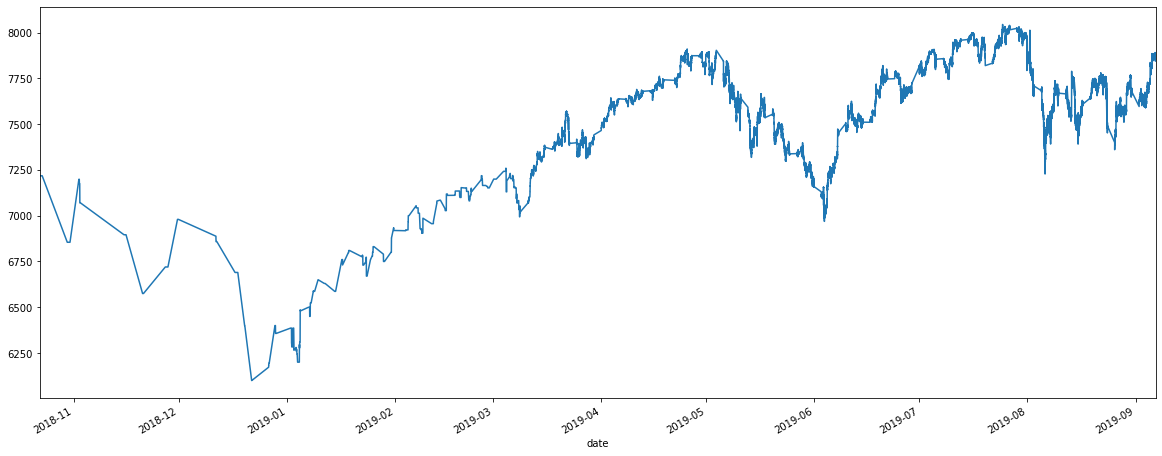

In [6]:
nq.close.plot(figsize=(20,8));

In [7]:
data = pd.DataFrame(nq.close)
data['max'] = data.close.rolling(200).max()
data['min'] = data.close.rolling(200).min()
data['ema'] = data.close.rolling(2000).mean()
#data['mean'] = (data['max'] + data['min']) / 2
#data['indicator'] = (data['close'] - data['mean']) / (data['max'] - data['min'])

data.tail()

,close,max,min,ema
date,,,,
2019-09-06 16:57:00,7867.50,7891.25,7844.5,7849.956750
2019-09-06 16:58:00,7868.00,7891.25,7844.5,7849.983000
2019-09-06 16:59:00,7869.75,7891.25,7844.5,7850.010000
2019-09-06 17:00:00,7869.75,7891.25,7844.5,7850.036750
2019-09-06 17:01:00,7870.50,7891.25,7844.5,7850.063375


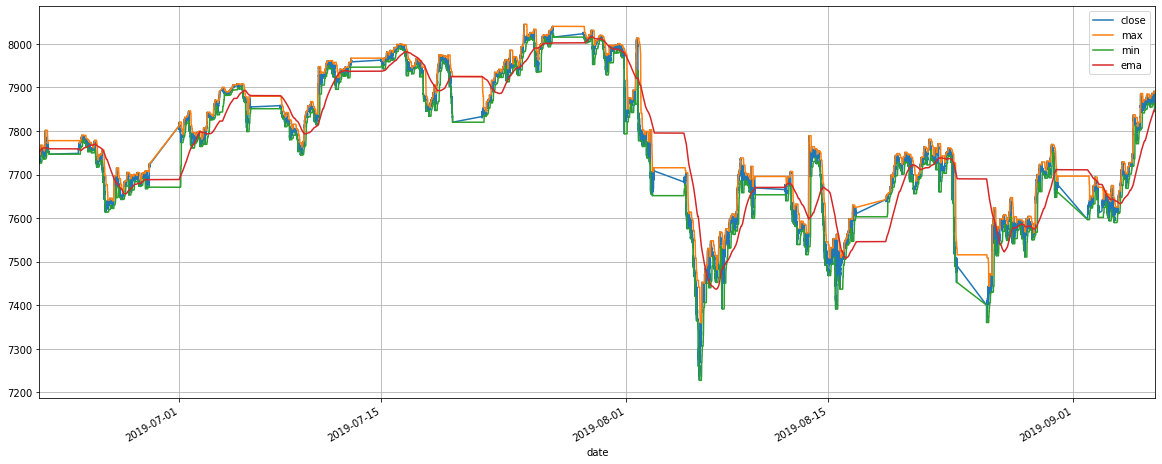

In [8]:
data[-75000:].plot(figsize=(20,8), grid=True);

In [9]:
avg_vol = nq.loc['20190621':].volume.rolling(60).sum().mean()
avg_vol

19761.370267186714

9881.436770634415


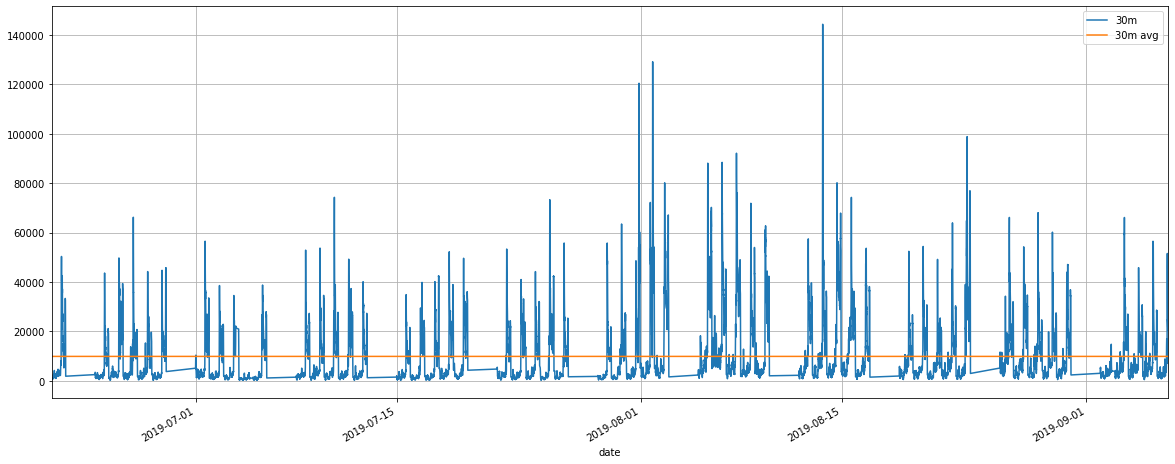

In [10]:
time_int = 30
df = nq.loc['20190621':]
avg = df.volume.rolling(time_int).sum().mean()
volume_df = pd.DataFrame({
    '{}m'.format(time_int): df.volume.rolling(time_int).sum(),
    '{}m avg'.format(time_int): avg,
})
print(avg)
volume_df.plot(figsize=(20, 8), grid=True);

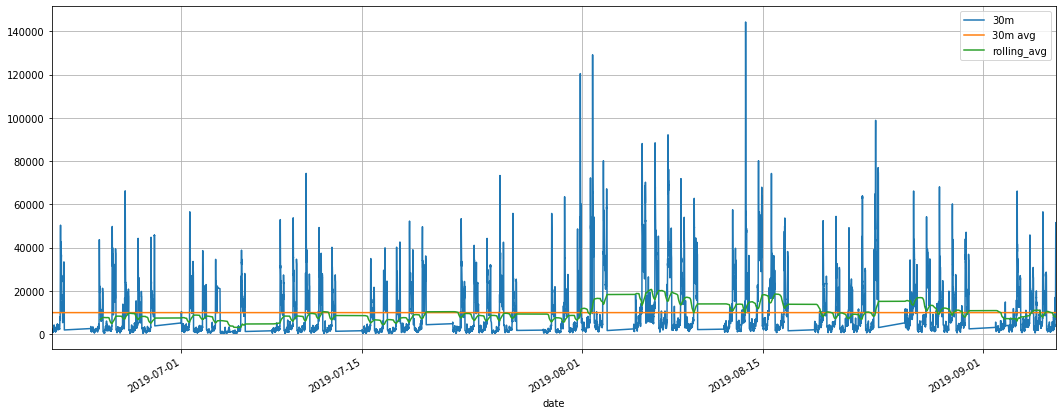

In [11]:
volume_df['rolling_avg'] = volume_df.iloc[:,0].rolling(2400).mean()
volume_df.plot(figsize=(18,7), grid=True);

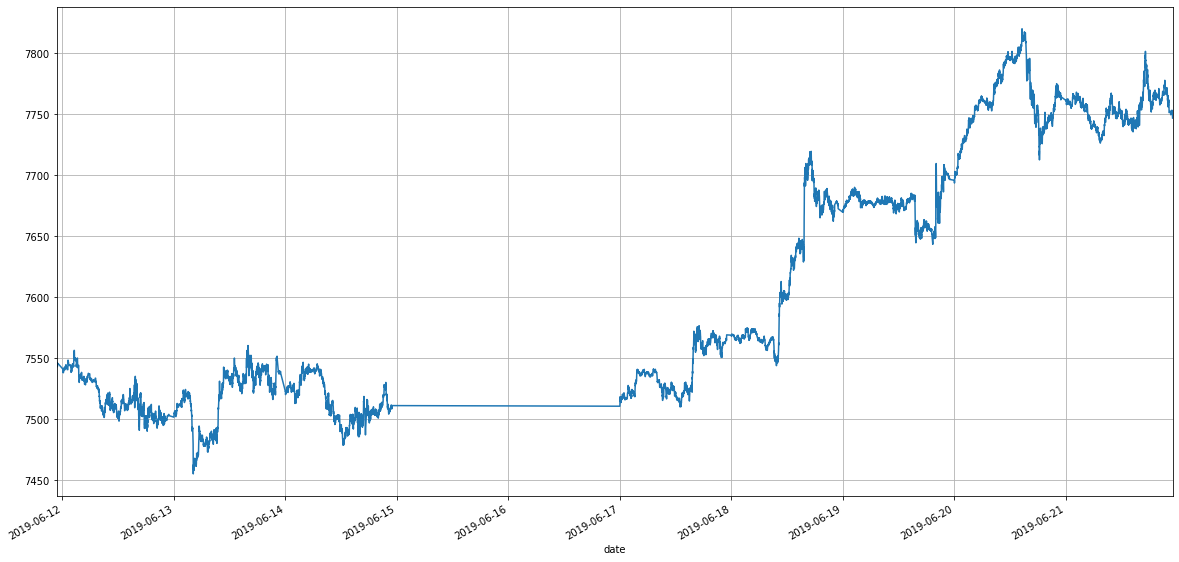

In [12]:
 nq.loc['20190611 22:45:00':'20190621'].close.plot(figsize=(20,10),grid=True);

In [13]:
class VolumeGrouper:
    def __init__(self, avg_vol):
        self.volume = 0
        self.counter = 0
        self.avg_vol = avg_vol
    def group(self, vol):
        self.volume += vol
        if self.volume >= self.avg_vol:
            self.volume -= self.avg_vol
            self.counter += 1
        return self.counter

In [14]:
vol_candles = nq.copy().reset_index()
grouper = VolumeGrouper(avg_vol)
vol_candles['label'] = vol_candles.volume.apply(grouper.group)

In [15]:
vol_candles = vol_candles.groupby('label').agg({'date': 'last',
                                  'open': 'first',
                                 'high': 'max',
                                 'low': 'min',
                                 'close': 'last',
                                 'volume': 'sum'})

In [16]:
#vol_candles.set_index('date', inplace=True)

In [17]:
vol_candles.head()

,date,open,high,low,close,volume
label,,,,,,
0,2019-05-21 16:10:00,7218.00,7910.75,6099.75,7459.50,19674
1,2019-06-10 18:17:00,7455.00,7603.50,6969.00,7588.25,19830
2,2019-06-13 06:46:00,7587.00,7626.25,7446.25,7479.25,19775
3,2019-06-13 21:02:00,7479.75,7562.50,7472.25,7521.75,19735
4,2019-06-14 06:31:00,7520.75,7552.75,7512.50,7539.00,19791


In [18]:
data = pd.DataFrame(vol_candles.close)
data['max'] = data.close.rolling(20).max()
data['min'] = data.close.rolling(20).min()
data['ema_fast'] = data.close.ewm(span=80).mean()
data['ema_slow'] = data.close.ewm(span=480).mean()
#data.reset_index(drop=True, inplace=True)
data.tail()

,close,max,min,ema_fast,ema_slow
label,,,,,
1344,7857.75,7882.5,7841.25,7763.897073,7666.712217
1345,7851.00,7882.5,7841.25,7766.047763,7667.481307
1346,7859.25,7882.5,7841.25,7768.349052,7668.281605
1347,7873.75,7882.5,7841.25,7770.951545,7669.139062
1348,7870.50,7882.5,7841.25,7773.409532,7669.979364


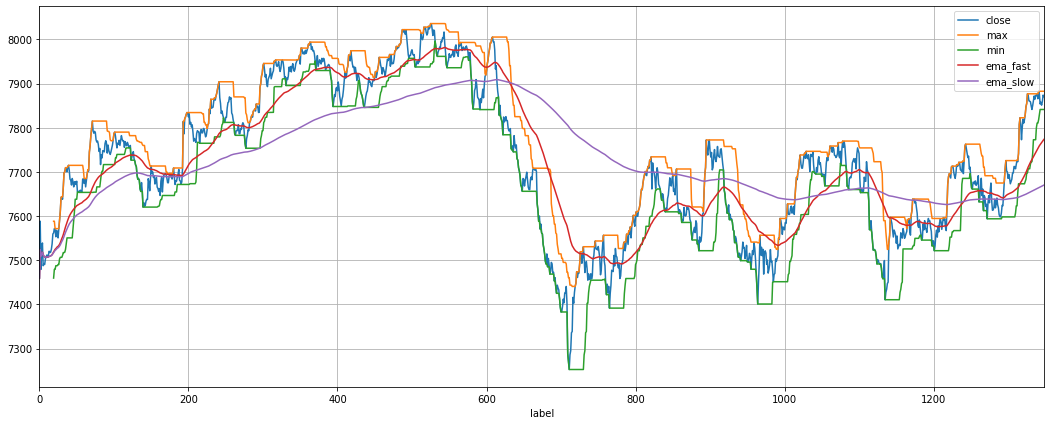

In [19]:
data.plot(figsize=(18,7), grid=True);

In [20]:
ema_diff = pd.DataFrame({'close': data['close'], 'ema_diff': data['ema_fast'] - data['ema_slow']})
ema_diff['return'] = ema_diff['close'].pct_change()
ema_diff['std'] = ema_diff['return'].expanding().std()
ema_diff['price_std'] = ema_diff['std'] * ema_diff['close']
ema_diff['norm'] = ema_diff['ema_diff']/ema_diff['price_std']
ema_diff['zscore'] = (ema_diff['ema_diff'] - ema_diff['ema_diff'].expanding().mean()) / ema_diff['ema_diff'].expanding().std()
#ema_diff['max']

In [21]:
ema_diff.tail()

,close,ema_diff,return,std,price_std,norm,zscore
label,,,,,,,
1344,7857.75,97.184856,0.000509,0.002487,19.539819,4.973683,1.194366
1345,7851.00,98.566456,-0.000859,0.002486,19.516722,5.050359,1.208594
1346,7859.25,100.067448,0.001051,0.002485,19.531164,5.123476,1.224113
1347,7873.75,101.812483,0.001845,0.002485,19.563753,5.204139,1.242301
1348,7870.50,103.430167,-0.000413,0.002484,19.548662,5.290908,1.259037


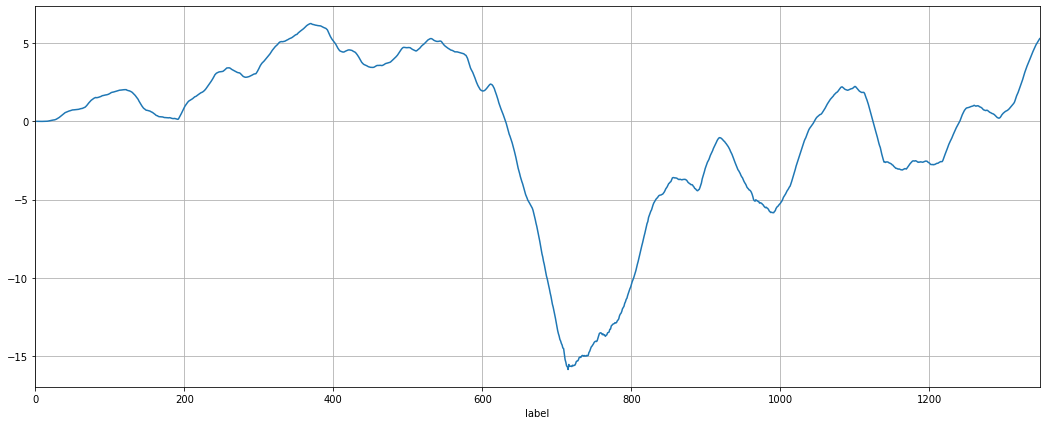

In [22]:
ema_diff['norm'].plot(figsize=(18,7), grid=True);

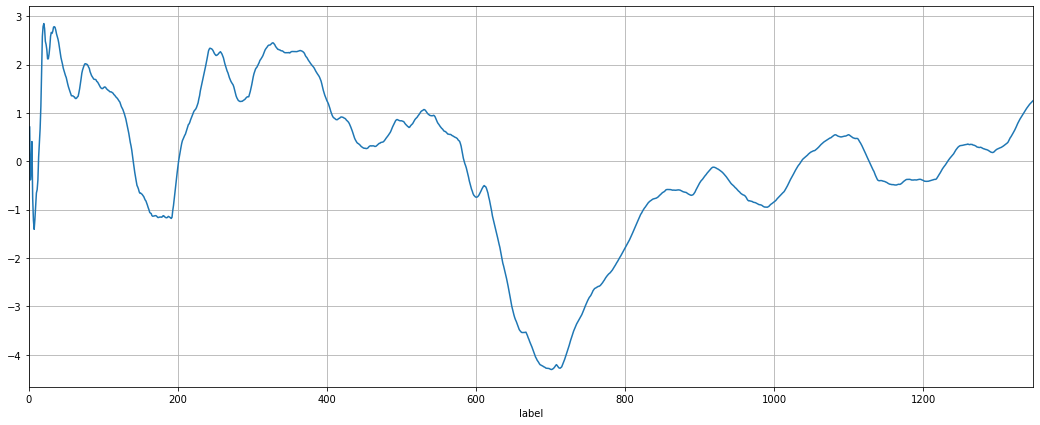

In [23]:
ema_diff['zscore'].plot(figsize=(18,7), grid=True);

In [24]:
def get_forecast(close, periods):
    ind = pd.DataFrame({'close': close})
    ind['max'] = ind.close.rolling(periods).max()
    ind['min'] = ind.close.rolling(periods).min()
    ind['mean'] = (ind['max'] + ind['min']) / 2
    ind['forecast'] = (ind['close'] - ind['mean']) / (ind['max'] - ind['min'])
    return ind

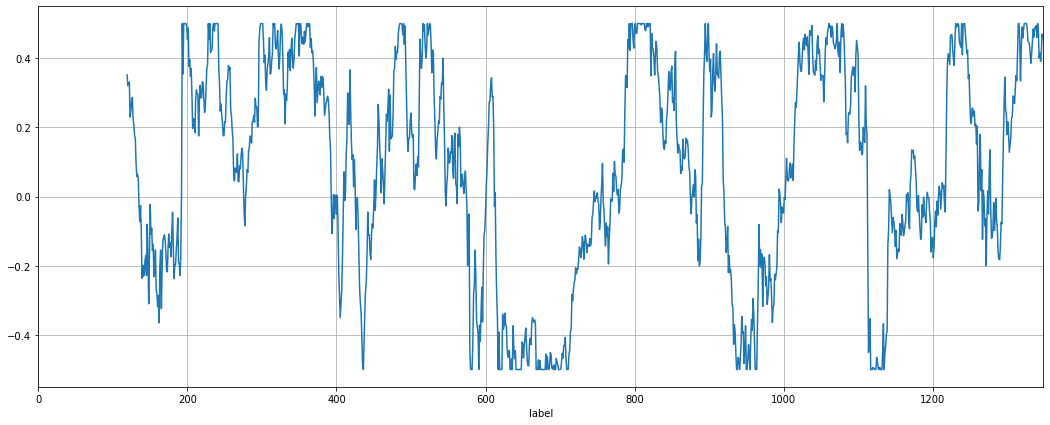

In [25]:
ind = get_forecast(data.close, 120)
ind.forecast.plot(figsize=(18,7), grid=True);

In [26]:
10 / ind.forecast.abs().mean()

36.27225169970771

In [27]:
10 / ema_diff.zscore.abs().mean()

8.36970611132025

In [28]:
10 / ema_diff.norm.abs().mean()

2.587821701688566

In [29]:
ind['ind'] = ind['forecast'] * 40 + ema_diff['norm'] * 5.6

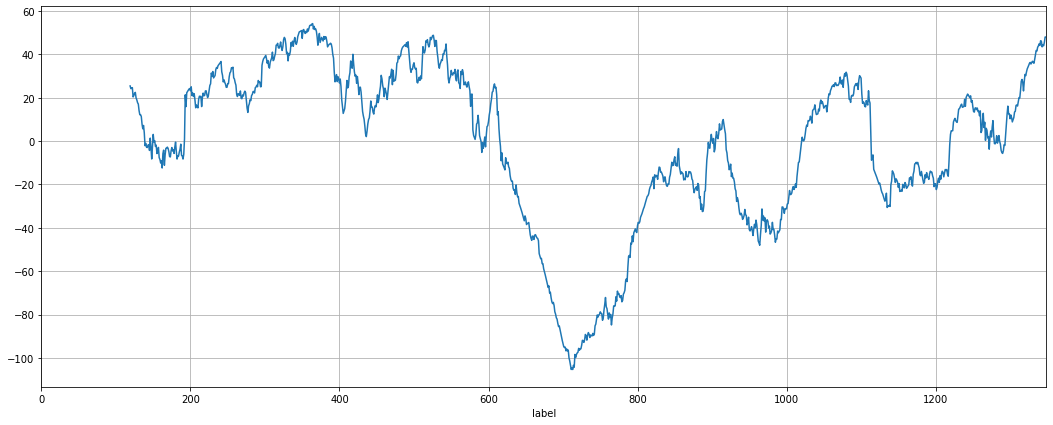

In [30]:
ind.ind.plot(figsize=(18, 7), grid=True);

In [31]:
norm_ind = pd.DataFrame({'breakout': ind['forecast'] * 40, 'ema_cross': ema_diff['norm'] * 5.6})
norm_ind['ema_cross'] = norm_ind['ema_cross'].clip(lower=-20, upper=20)
norm_ind['ema_cross_shift'] = norm_ind['ema_cross'].shift(20)
norm_ind.tail()

,breakout,ema_cross,ema_cross_shift
label,,,
1344,16.571429,20.0,14.057635
1345,15.636364,20.0,14.904188
1346,16.779221,20.0,15.816282
1347,18.787879,20.0,16.733636
1348,18.337662,20.0,17.569706


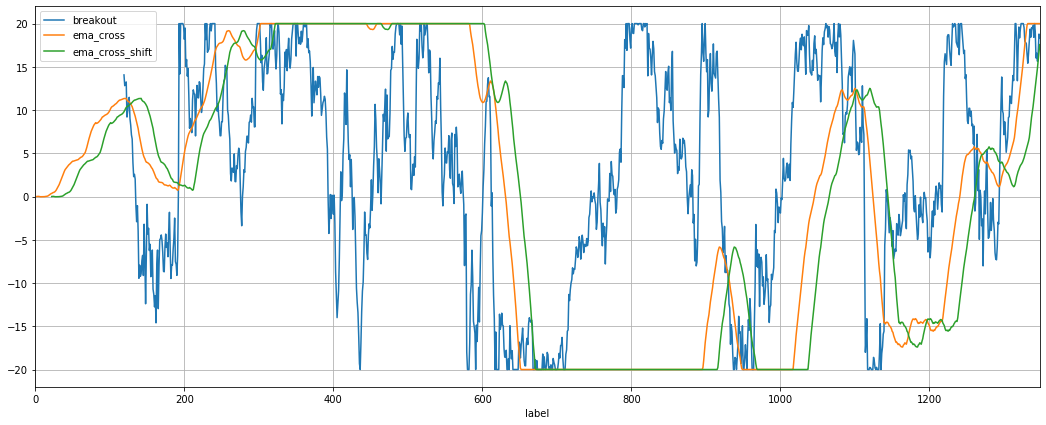

In [32]:
norm_ind.plot(figsize=(18,7), grid=True);

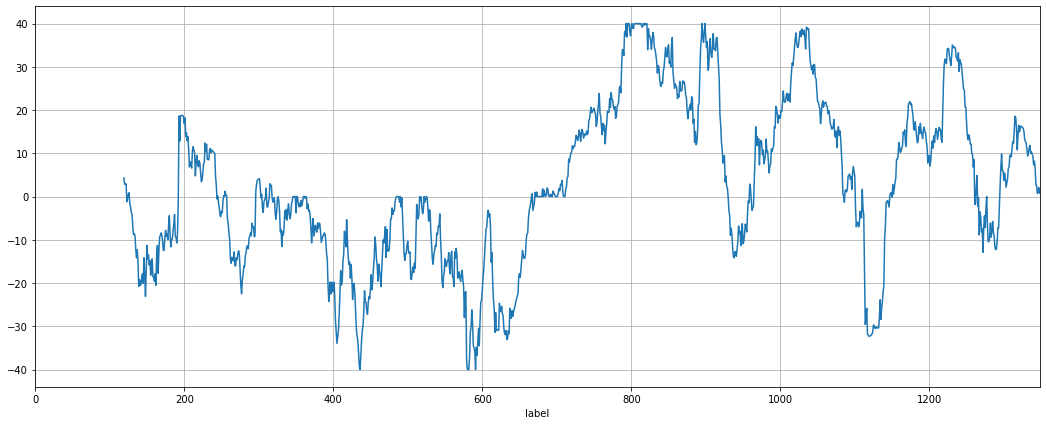

In [33]:
(norm_ind['breakout'] - norm_ind['ema_cross_shift']).plot(figsize=(18,7), grid=True);

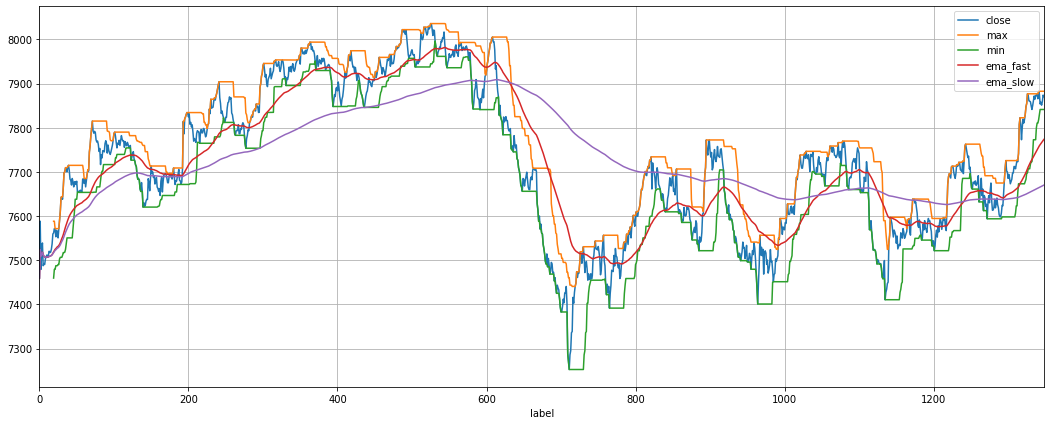

In [34]:
data.plot(figsize=(18,7), grid=True);

In [35]:
periods = [7, 15, 30, 120, 240, 480]

In [36]:
forecasts = pd.DataFrame()
for period in periods:
    forecasts[period] = get_forecast(data.close, period)['forecast']
forecasts.tail()

,7,15,30,120,240,480
label,,,,,,
1344,-0.360870,-0.100000,0.274487,0.414286,0.447564,0.448625
1345,-0.500000,-0.263636,0.212984,0.390909,0.433263,0.434613
1346,-0.238095,-0.063636,0.288155,0.419481,0.450742,0.451738
1347,0.222222,0.230769,0.420273,0.469697,0.481462,0.481837
1348,0.280000,0.119048,0.354103,0.458442,0.474576,0.475091


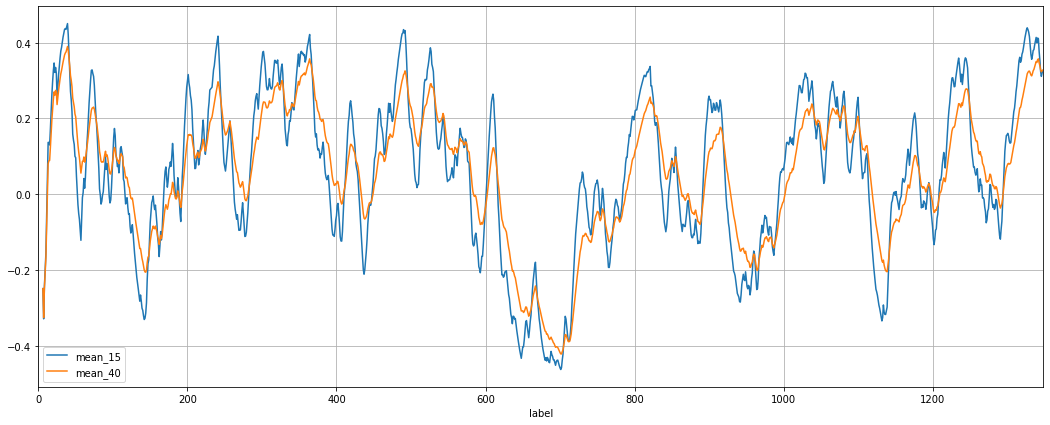

In [37]:
x = pd.DataFrame({'mean_15': forecasts.mean(axis=1).ewm(span=15).mean(),
                  'mean_40': forecasts.mean(axis=1).ewm(span=40).mean()
                  #'forecast': forecasts.mean(axis=1)
                 })
x.plot(figsize=(18,7),grid=True);

In [38]:
forecasts.corr()

,7,15,30,120,240,480
7,1.000000,0.805793,0.618935,0.384048,0.287693,0.265374
15,0.805793,1.000000,0.843046,0.518965,0.408224,0.361711
30,0.618935,0.843046,1.000000,0.660263,0.528286,0.452526
120,0.384048,0.518965,0.660263,1.000000,0.866933,0.719931
240,0.287693,0.408224,0.528286,0.866933,1.000000,0.835360
480,0.265374,0.361711,0.452526,0.719931,0.835360,1.000000


In [39]:
def get_emas(close, periods):
    ind = pd.DataFrame({'close': close})
    ind['ema_fast'] = close.ewm(span=periods[0]).mean()
    ind['ema_slow'] = close.ewm(span=periods[1]).mean()
    ind['diff'] = ind['ema_fast'] - ind['ema_slow']
    return ind

In [40]:
ema_pairs = [(60, 240), (120, 640), (360, 1120)]

In [41]:
emas = pd.DataFrame()
for pair in ema_pairs:
    emas[pair] = get_emas(data.close, pair)['diff']
emas.tail()

,"(60, 240)","(120, 640)","(360, 1120)"
label,,,
1344,98.666630,64.132872,-11.247521
1345,99.429256,65.510896,-10.581469
1346,100.335729,66.968682,-9.890685
1347,101.532981,68.588101,-9.152965
1348,102.574157,70.128723,-8.432255


In [42]:
emas.corr()

,"(60, 240)","(120, 640)","(360, 1120)"
"(60, 240)",1.000000,0.821060,0.409793
"(120, 640)",0.821060,1.000000,0.822916
"(360, 1120)",0.409793,0.822916,1.000000


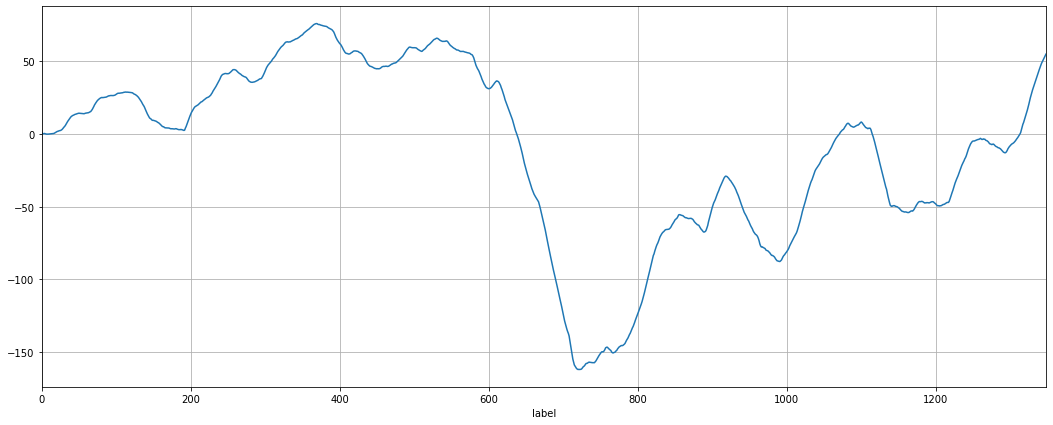

In [43]:
emas.mean(axis=1).plot(figsize=(18,7), grid=True);

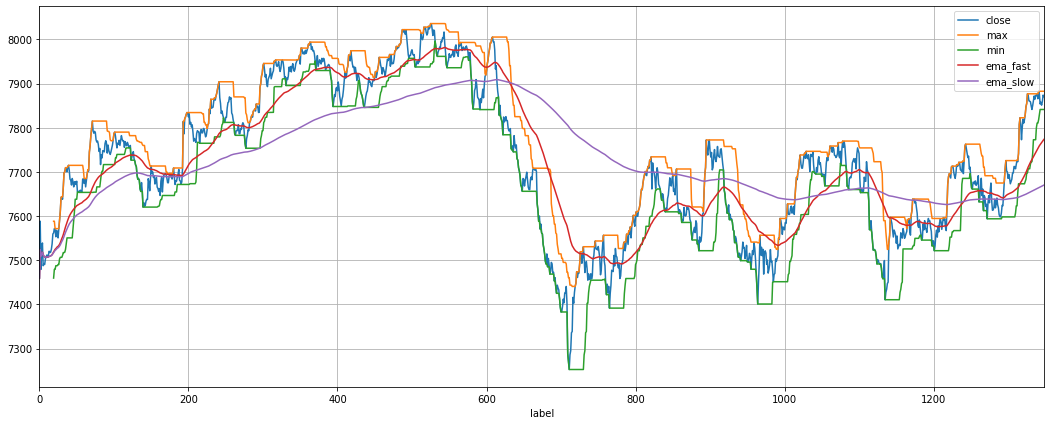

In [44]:
data.plot(figsize=(18,7), grid=True);

In [45]:
10/ emas.mean(axis=1).abs().mean()

0.20637633178655607

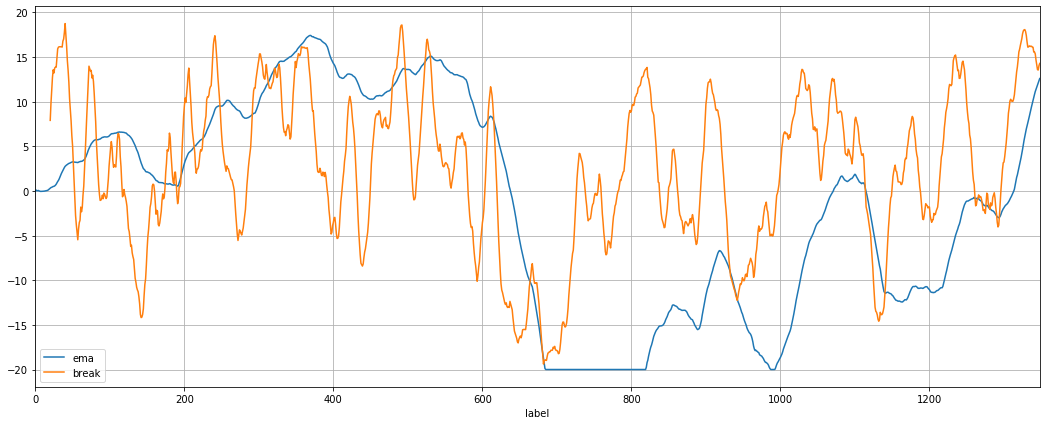

In [46]:
indices = pd.DataFrame({'ema': (emas.mean(axis=1) * .23).clip(lower=-20, upper=20),
                       'break': forecasts.mean(axis=1).rolling(15).mean() * 40
                       })
indices.plot(figsize=(18,7), grid=True);

In [47]:
indices.corr()

,ema,break
ema,1.000000,0.383885
break,0.383885,1.000000


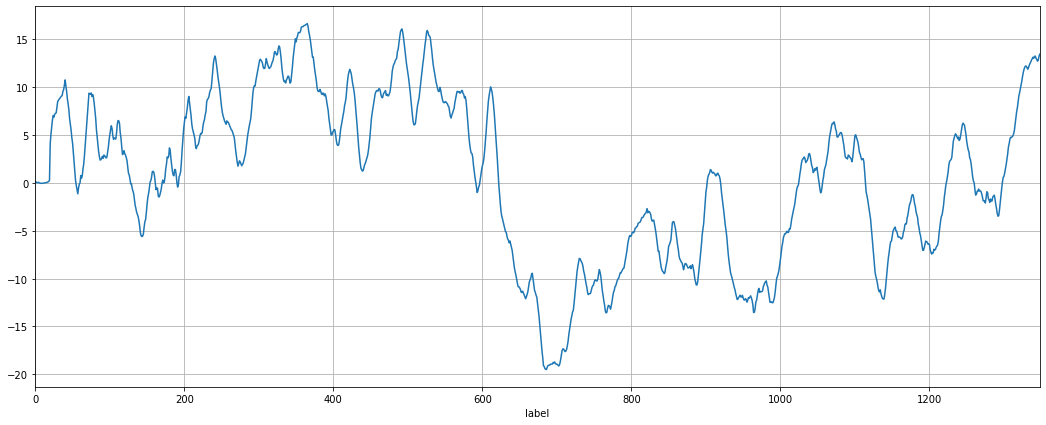

In [48]:
indices.mean(axis=1).plot(figsize=(18,7), grid=True);

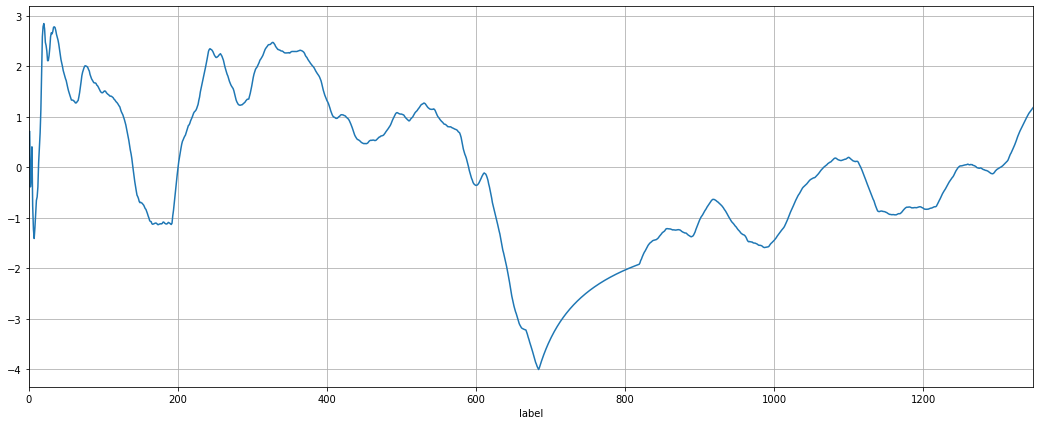

In [49]:
((indices['ema'] - indices['ema'].expanding().mean()) / indices['ema'].expanding().std()).plot(figsize=(18,7), grid=True);

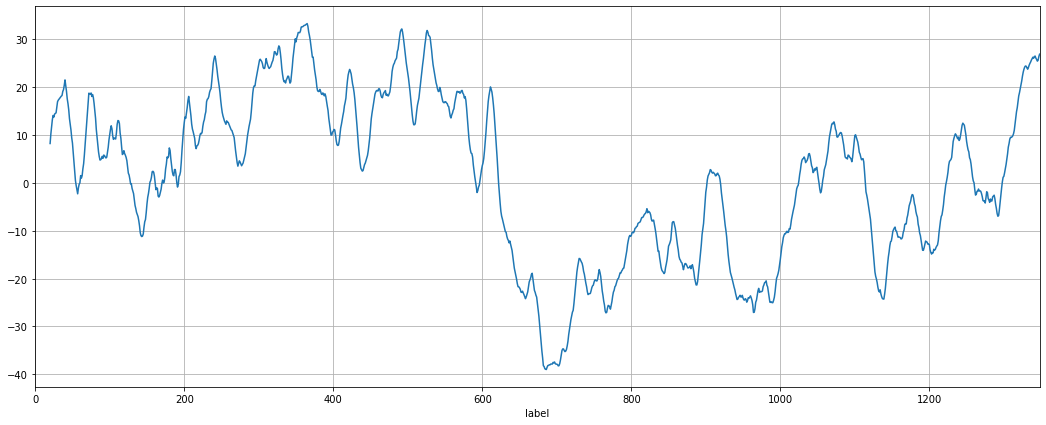

In [50]:
(indices['ema'] + indices['break']).plot(figsize=(18,7), grid=True);

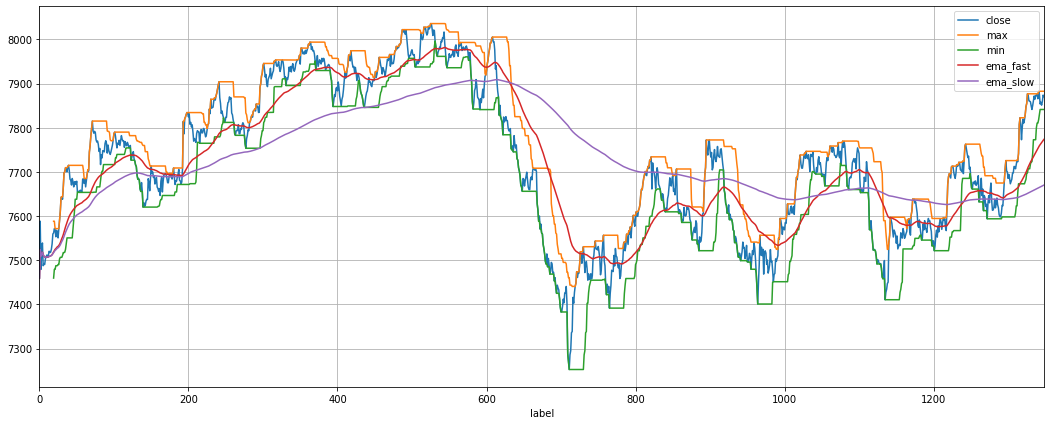

In [51]:
data.plot(figsize=(18,7), grid=True);

In [52]:
def get_ATR(data, periods):
    TR = pd.DataFrame({'A': (data['high'] - data['low']),
                       'B': (data['high'] - data['close']).abs(),
                       'C': (data['low'] - data['close']).abs()
                      })
    TR['TR'] = TR.max(axis=1)
    TR['ATR'] = TR['TR'].rolling(periods).mean()
    return TR.ATR

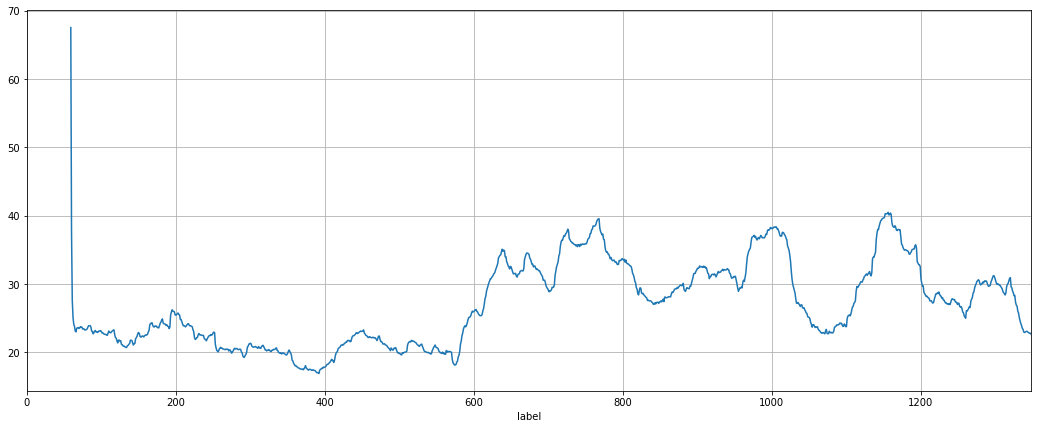

In [53]:
get_ATR(vol_candles, 60).plot(figsize=(18,7), grid=True);

In [54]:
periods = [10, 20, 40, 80, 160]

In [55]:
multi_period = pd.DataFrame({'close': data.close})

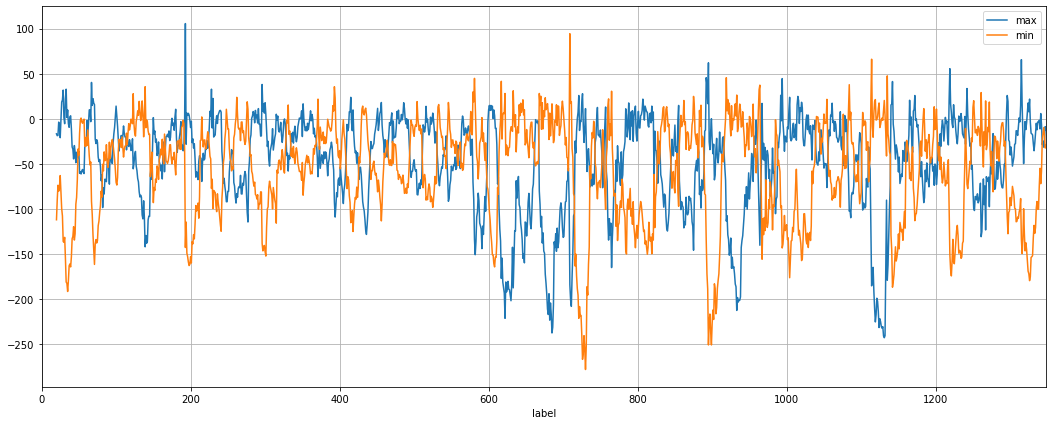

In [56]:
multi_period['max'] = multi_period.close - multi_period.close.shift(1).rolling(20).max()
multi_period['min'] = multi_period.close.shift(1).rolling(20).min() - multi_period.close
multi_period[['max', 'min']].plot(figsize=(18,7), grid=True);

In [57]:
multi_period_max = pd.DataFrame({'close': data.close})
multi_period_min = pd.DataFrame({'close': data.close})
for period in periods:
    multi_period_max[period] = multi_period.close - multi_period.close.shift(1).rolling(period).max()
    multi_period_min[period] = multi_period.close.shift(1).rolling(20).min() - multi_period.close
multi_period_avg = pd.DataFrame({
    #'close': data.close,
    'max': multi_period_max.mean(axis=1).clip(upper=2200, lower=800),
    'min': multi_period_min.mean(axis=1).clip(upper=2200, lower=800),
})
multi_period_avg.tail()

,max,min
label,,
1344,1289.00,1295.875000
1345,1282.25,1300.375000
1346,1290.50,1294.875000
1347,1305.00,1285.208333
1348,1301.75,1287.375000


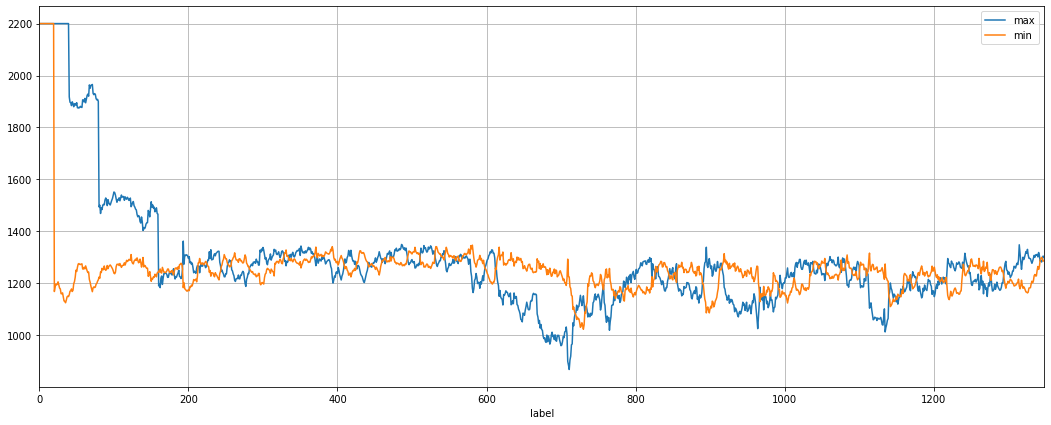

In [58]:
multi_period_avg.plot(figsize=(18,7), grid=True);

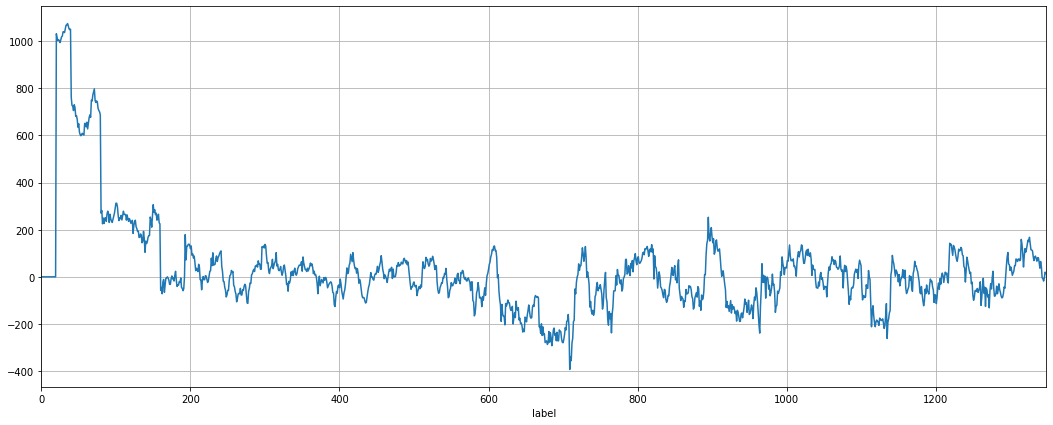

In [59]:
(multi_period_avg['max'] - multi_period_avg['min']).plot(figsize=(18,7), grid=True);

In [60]:
from functools import partial

def get_min_max(data, period):
    return pd.DataFrame({
        'max': (data - data.shift(1).rolling(period).max()) > 0,
        'min': (data.shift(1).rolling(period).min() - data) > 0
    })

def majority_function(data):
    return (0.5 + ((data.sum(axis=1) - 0.5) / data.count(axis=1))).round(0)

def get_min_max_df(data, periods, func=get_min_max):
    min_max_func = partial(func, data)
    mins = pd.DataFrame()
    maxs = pd.DataFrame()
    for period in periods:
        df = min_max_func(period)
        mins[period] = df['min']
        maxs[period] = df['max']
    return {'min': mins,
           'max': maxs}

def get_signals(data, periods, func=get_min_max_df):
    min_max = func(data, periods)
    #return min_max['min']
    
    return pd.DataFrame({
        'signal': majority_function(min_max['max']) - majority_function(min_max['min'])
    })
    

In [61]:
get_signals(data.close, periods).tail()

,signal
label,
1344,0.0
1345,-1.0
1346,0.0
1347,0.0
1348,0.0


In [62]:
signals = pd.DataFrame({
    'close': data.close,
    'signal': get_signals(data.close, periods)['signal']
})

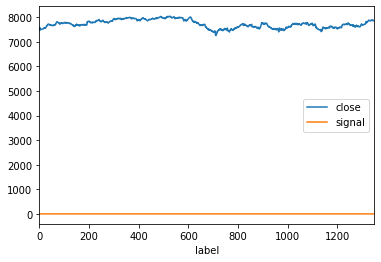

In [63]:
signals.plot();

In [64]:
signals['value'] = signals['close'] * signals['signal']

In [65]:
signals.tail()

,close,signal,value
label,,,
1344,7857.75,0.0,0.0
1345,7851.00,-1.0,-7851.0
1346,7859.25,0.0,0.0
1347,7873.75,0.0,0.0
1348,7870.50,0.0,0.0


In [66]:
signals['value'] = signals.value.map(lambda x: x if x != 0 else np.nan)

In [67]:
signals['buy'] = signals['value'].map(lambda x: x if x > 0 else np.nan)
signals['sell'] = signals['value'].map(lambda x: -x if x < 0 else np.nan)

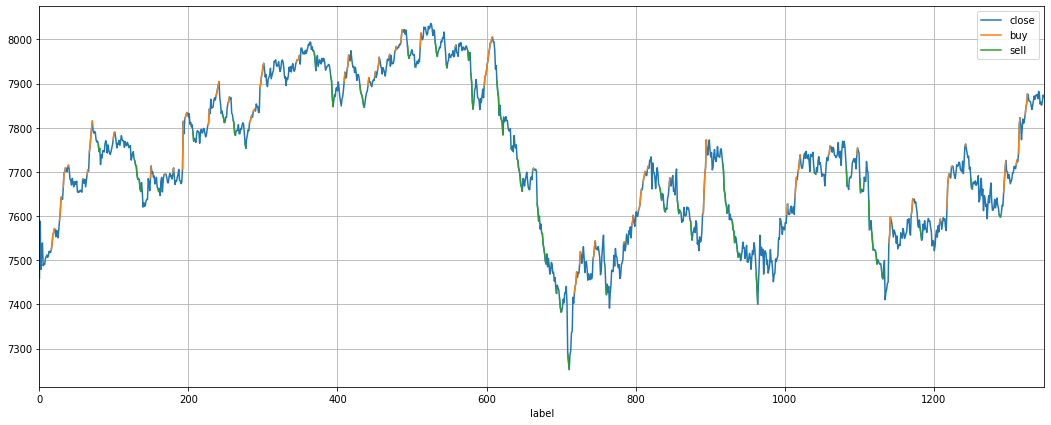

In [68]:
signals[['close', 'buy', 'sell']].plot(figsize=(18, 7), grid=True);

In [69]:
signals['cum_signal'] = signals.signal.expanding().apply(lambda x: x.sum().clip(min=-1, max=1), raw=False)

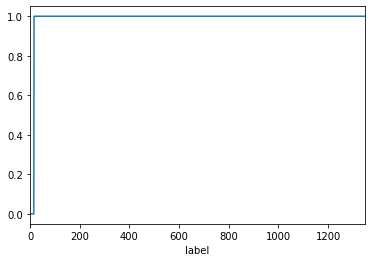

In [70]:
signals['cum_signal'].plot()

In [71]:
#signals['filter'] = np.sign(emas.mean(axis=1))
signals['filter'] = np.sign(data.close - data.ema_fast)
signals['atr'] = get_ATR(vol_candles, 80)

In [72]:
number_of_trades = 0
entry = 0
for row in signals.itertuples():
    if row.Index == 0:
        continue
    # if there's no position signal is to be filtered
    if signals.loc[row.Index-1, 'cum_signal'] == 0 and row.filter * row.signal != 1:
        signals.loc[row.Index, 'cum_signal'] = 0
        continue
    else:
        signals.loc[row.Index, 'cum_signal'] = (signals.loc[row.Index-1, 'cum_signal'] + row.signal).clip(max=1, min=-1)
        
    # create stop loss
    if signals.loc[row.Index, 'cum_signal'] - signals.loc[row.Index-1, 'cum_signal'] != 0:
        sl = signals.loc[row.Index, 'close'] - signals.loc[row.Index, 'cum_signal'] * signals.loc[row.Index, 'atr'] * 1
        signals.loc[row.Index, 'sl'] = sl
    if not signals.loc[row.Index, 'sl']:
        signals.loc[row.Index, 'sl'] = signals.loc[row.Index-1, 'sl']
        
    # apply stop loss
    if signals.loc[row.Index, 'cum_signal'] == 1 and signals.loc[row.Index, 'close'] < sl:
        signals.loc[row.Index, 'cum_signal'] = 0
    elif signals.loc[row.Index, 'cum_signal'] == -1 and signals.loc[row.Index, 'close'] > sl:
        signals.loc[row.Index, 'cum_signal'] = 0
        
    # count trades
    if signals.loc[row.Index, 'cum_signal'] != signals.loc[row.Index-1, 'cum_signal']:
        number_of_trades += 1

In [73]:
signals.tail()

,close,signal,value,buy,sell,cum_signal,filter,atr,sl
label,,,,,,,,,
1344,7857.75,0.0,NaN,NaN,NaN,1.0,1.0,26.915625,NaN
1345,7851.00,-1.0,-7851.0,NaN,7851.0,0.0,1.0,26.675000,7851.0
1346,7859.25,0.0,NaN,NaN,NaN,0.0,1.0,26.562500,NaN
1347,7873.75,0.0,NaN,NaN,NaN,0.0,1.0,25.818750,NaN
1348,7870.50,0.0,NaN,NaN,NaN,0.0,1.0,25.390625,NaN


In [74]:
signals['value'] = signals['close'] * signals['cum_signal']
signals['value'] = signals.value.map(lambda x: x if x != 0 else np.nan)
signals['long'] = signals['value'].map(lambda x: x if x > 0 else np.nan)
signals['short'] = signals['value'].map(lambda x: -x if x < 0 else np.nan)

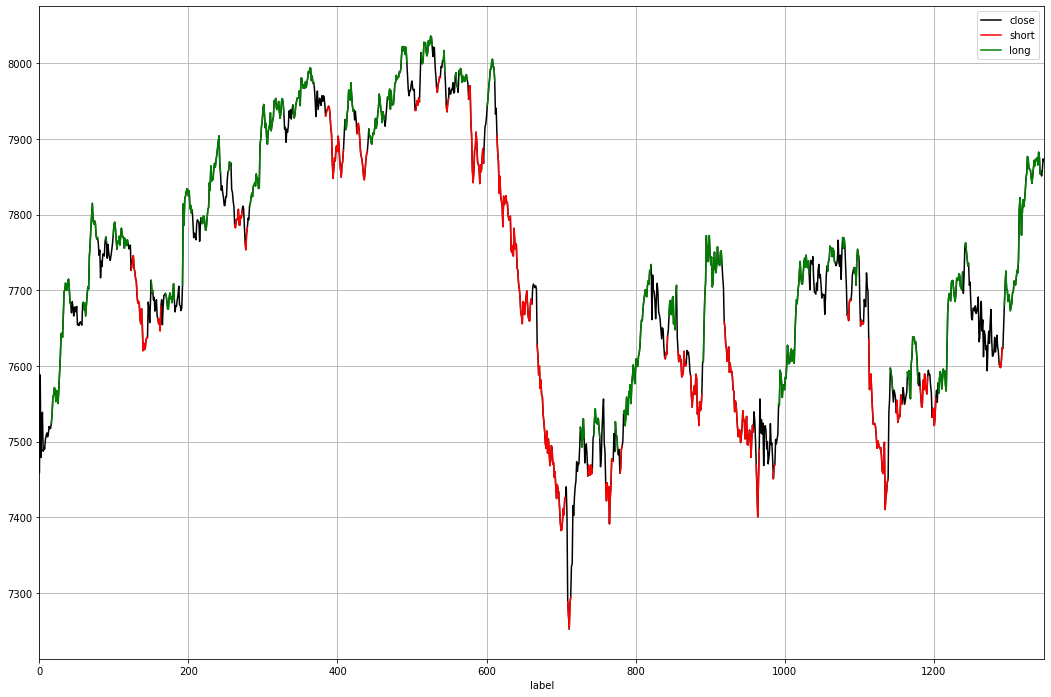

In [75]:
signals[['close', 'short', 'long']].plot(figsize=(18, 12), grid=True, color=['k', 'r', 'g']);

In [76]:
#signals.tail(200)

In [77]:
signals.head()

,close,signal,value,buy,sell,cum_signal,filter,atr,sl,long,short
label,,,,,,,,,,,
0,7459.50,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,7588.25,0.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN
2,7479.25,0.0,NaN,NaN,NaN,0.0,-1.0,NaN,NaN,NaN,NaN
3,7521.75,0.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN
4,7539.00,0.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN


In [78]:
signals['long_pnl'] = signals.long.diff().fillna(0)
signals['short_pnl'] = - signals.short.diff().fillna(0)

In [79]:
long_pnl = signals.long_pnl.sum()
short_pnl = signals.short_pnl.sum()
pnl = long_pnl + short_pnl
long_pnl, short_pnl, pnl

(1345.75, 712.25, 2058.0)

fast filter: 773 (980 with 60minute volumes)
slow filter: 404

In [80]:
signals['pnl'] = signals['long_pnl'] + signals['short_pnl']
pnl_p = signals[signals['pnl']>0].pnl
pnl_m = signals[signals['pnl']<0].pnl
pnl_p.count(), pnl_m.count(), pnl_p.count()/(pnl_p.count()+pnl_m.count())

(497, 409, 0.5485651214128036)

In [81]:
pnl_p.sum(), pnl_m.sum(), pnl_p.sum()/ pnl_m.abs().sum()

(6600.0, -4542.0, 1.453104359313078)

In [82]:
signals['date'] = vol_candles['date']

In [83]:
signals.set_index('date', inplace=True)

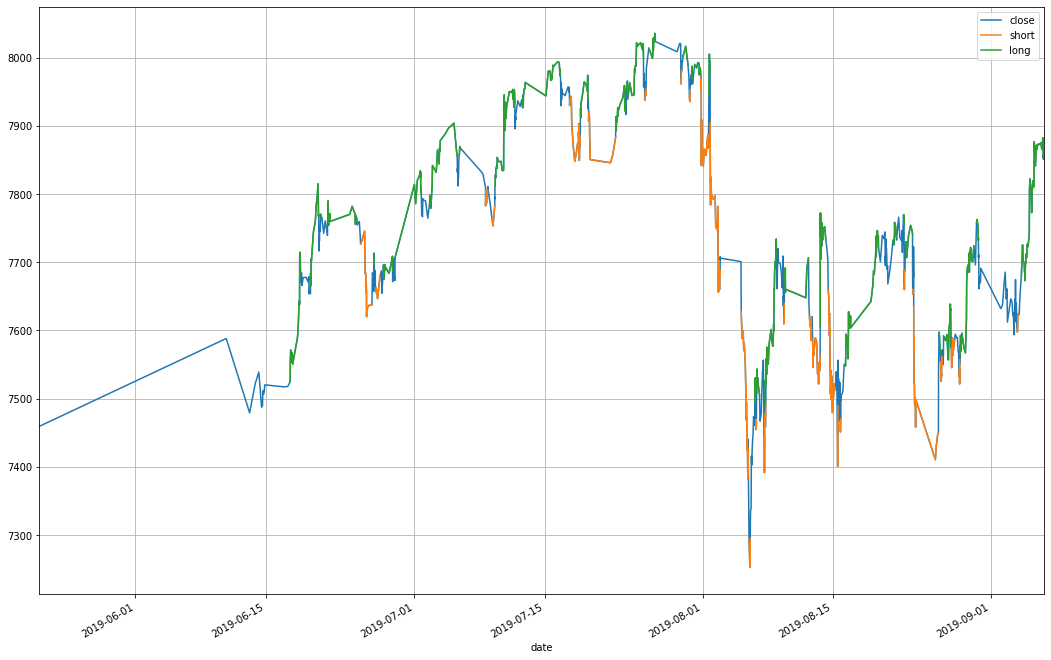

In [84]:
signals[['close', 'short', 'long']].plot(figsize=(18, 12), grid=True);

In [108]:
signals.tail(30)

,close,signal,value,buy,sell,cum_signal,filter,atr,sl,long,short,long_pnl,short_pnl,pnl
date,,,,,,,,,,,,,,
2019-09-05 10:31:00,7800.25,0.0,7800.25,NaN,NaN,1.0,1.0,29.046875,NaN,7800.25,NaN,27.50,-0.0,27.50
2019-09-05 12:58:00,7819.50,0.0,7819.50,NaN,NaN,1.0,1.0,28.862500,NaN,7819.50,NaN,19.25,-0.0,19.25
2019-09-05 15:04:00,7810.50,0.0,7810.50,NaN,NaN,1.0,1.0,28.593750,NaN,7810.50,NaN,-9.00,-0.0,-9.00
2019-09-05 15:34:00,7818.00,0.0,7818.00,NaN,NaN,1.0,1.0,28.350000,NaN,7818.00,NaN,7.50,-0.0,7.50
2019-09-05 15:44:00,7829.75,1.0,7829.75,7829.75,NaN,1.0,1.0,28.312500,NaN,7829.75,NaN,11.75,-0.0,11.75
2019-09-05 15:58:00,7847.25,1.0,7847.25,7847.25,NaN,1.0,1.0,28.375000,NaN,7847.25,NaN,17.50,-0.0,17.50
2019-09-05 16:07:00,7855.00,1.0,7855.00,7855.00,NaN,1.0,1.0,28.350000,NaN,7855.00,NaN,7.75,-0.0,7.75
2019-09-05 16:18:00,7876.75,1.0,7876.75,7876.75,NaN,1.0,1.0,28.468750,NaN,7876.75,NaN,21.75,-0.0,21.75
2019-09-05 16:31:00,7873.00,0.0,7873.00,NaN,NaN,1.0,1.0,28.459375,NaN,7873.00,NaN,-3.75,-0.0,-3.75


In [122]:
interval = pd.Series(signals.index).diff().loc[10:]
interval.tail(20)

1329   00:23:00
1330   00:35:00
1331   00:30:00
1332   00:43:00
1333   00:58:00
1334   00:48:00
1335   00:42:00
1336   00:24:00
1337   03:52:00
1338   03:13:00
1339   04:15:00
1340   02:35:00
1341   02:34:00
1342   00:39:00
1343   00:28:00
1344   00:13:00
1345   00:14:00
1346   00:25:00
1347   00:25:00
1348   00:10:00
Name: date, dtype: timedelta64[ns]

In [124]:
interval.mean()

Timedelta('0 days 01:30:20.164301')

In [86]:
daily = pd.DataFrame()
daily['close'] = signals['close'].resample('D').last()
daily['pnl'] = (signals['long_pnl'] + signals['short_pnl']).resample('D').sum()
daily.tail()

,close,pnl
date,,
2019-09-02,7612.25,0.00
2019-09-03,7624.25,-21.25
2019-09-04,7726.50,47.25
2019-09-05,7864.50,138.00
2019-09-06,7870.50,-6.75


In [87]:
daily['dollars'] = 0
daily.iloc[0,2] = 25000

In [88]:
daily.head()

,close,pnl,dollars
date,,,
2019-05-21,7459.5,0.0,25000
2019-05-22,NaN,0.0,0
2019-05-23,NaN,0.0,0
2019-05-24,NaN,0.0,0
2019-05-25,NaN,0.0,0


In [89]:
multiplier = 20

In [90]:
daily['dollars'] = 25000 + daily.pnl.cumsum() * multiplier

In [91]:
daily.tail()

,close,pnl,dollars
date,,,
2019-09-02,7612.25,0.00,63015.0
2019-09-03,7624.25,-21.25,62590.0
2019-09-04,7726.50,47.25,63535.0
2019-09-05,7864.50,138.00,66295.0
2019-09-06,7870.50,-6.75,66160.0


In [92]:
daily['return'] = daily.dollars.pct_change()

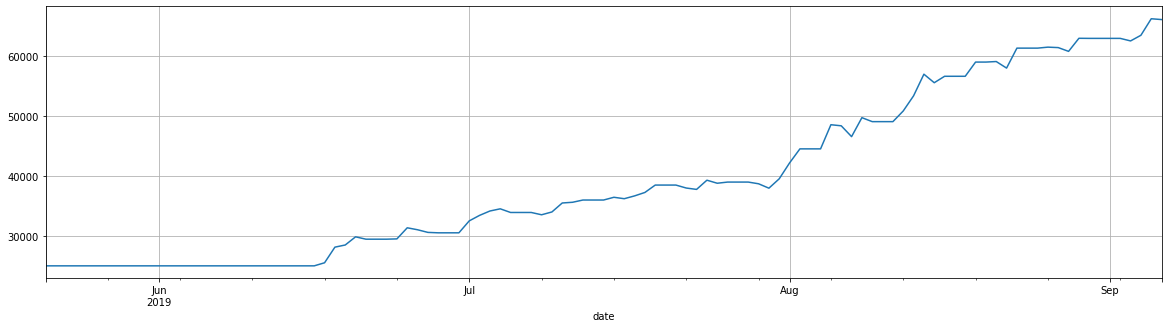

In [93]:
daily.dollars.plot(figsize=(20,5), grid=True);

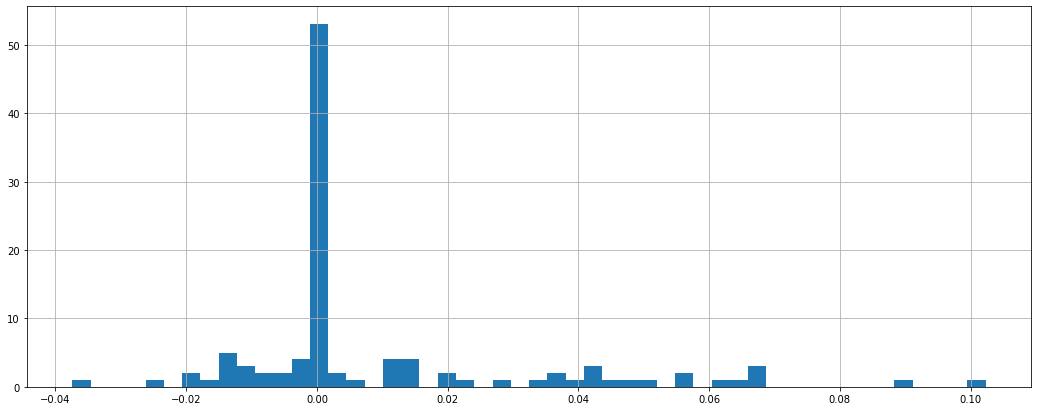

In [94]:
daily['return'].hist(bins=50,figsize=(18,7), grid=True);

In [95]:
daily.tail()

,close,pnl,dollars,return
date,,,,
2019-09-02,7612.25,0.00,63015.0,0.000000
2019-09-03,7624.25,-21.25,62590.0,-0.006744
2019-09-04,7726.50,47.25,63535.0,0.015098
2019-09-05,7864.50,138.00,66295.0,0.043441
2019-09-06,7870.50,-6.75,66160.0,-0.002036


In [96]:
from pyfolio.timeseries import perf_stats

/home/tomek/ib_insync/.env/lib/python3.6/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [97]:
perf_stats(daily['return'])

Annual return            8.487427
Cumulative returns       1.646400
Annual volatility        0.385225
Sharpe ratio             6.105774
Calmar ratio           207.216916
Stability                0.966868
Max drawdown            -0.040959
Omega ratio              4.993150
Sortino ratio           23.020115
Skew                          NaN
Kurtosis                      NaN
Tail ratio               4.641852
Daily value at risk     -0.039200
dtype: float64

In [98]:
(daily['return'] + 1).product()

2.646399999999998

In [99]:
number_of_trades

140

In [100]:
spread = .25 * multiplier
commission = 1.18 + .85 
cost_of_trades = number_of_trades * (spread + commission)
cost_of_trades

984.1999999999999

In [101]:
days = (daily.index[-1] - daily.index[0]).days #pd.to_datetime('20190613')).days
days

108

In [102]:
trades_per_day = number_of_trades / days
trades_per_day

1.2962962962962963

In [103]:
pnl_in_dollars = pnl*multiplier

In [104]:
cost_of_trades / (pnl_in_dollars)

0.02391156462585034

In [105]:
mean = daily['return'].mean() * 252
std = daily['return'].std() * (252**.5)
mean, std

(2.3520973694581637, 0.385225078342419)

In [106]:
mean/std

6.105774264694758

In [107]:
#daily.to_pickle('cl_return.pickle')